In [1]:
import numpy as np
import qutip as qt

import numpy as np
import qutip as qt

# -----------------------------
# Ising Hamiltonian
# H = -J Σ Z_i Z_{i+1} - h Σ X_i
# -----------------------------
def ising_hamiltonian(L, J=1.0, h=1.0):
    sx, sz = qt.sigmax(), qt.sigmaz()
    I = qt.qeye(2)

    def embed(op, i):
        ops = [I] * L
        ops[i] = op
        return qt.tensor(ops)

    H = 0
    for i in range(L - 1):
        H += -J * embed(sz, i) * embed(sz, i + 1)
    for i in range(L):
        H += -h * embed(sx, i)
    return H

def heisenberg_xxx_hamiltonian(L, J=1.0, h=1.0):
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
    I = qt.qeye(2)

    def embed(op, i):
        ops = [I] * L
        ops[i] = op
        return qt.tensor(ops)

    H = 0

    # XXX couplings
    for i in range(L - 1):
        H += J * (
            embed(sx, i) * embed(sx, i + 1)
            + embed(sy, i) * embed(sy, i + 1)
            + embed(sz, i) * embed(sz, i + 1)
        )

    # Z field
    for i in range(L):
        H += h * embed(sz, i)

    return H

# -----------------------------
# Collapse operators (example: Pauli x,y,z at each site)
# Lindblad convention: c = sqrt(gamma) * A
# -----------------------------
def pauli_c_ops(L, gamma):
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
    I = qt.qeye(2)

    def embed(op, i):
        ops = [I] * L
        ops[i] = op
        return qt.tensor(ops)

    c_ops = []
    for i in range(L):
        for op in (sx, sy, sz):
            c_ops.append(np.sqrt(gamma) * embed(op, i))
    return c_ops

# -----------------------------
# Middle-site Z observable
# -----------------------------
def Z_middle(L):
    sz = qt.sigmaz()
    I = qt.qeye(2)
    i = L // 2
    return qt.tensor([I]*i + [sz] + [I]*(L-i-1))

def XX_middle(L):
    sx = qt.sigmax()
    I = qt.qeye(2)
    i = L // 2
    return qt.tensor([I]*i + [sx] + [sx] + [I]*(L-i-2))

# -----------------------------
# "Entropy" observable for density matrices
# We compute S( rho_left ) across the middle bipartition.
# This is the von Neumann entropy of the reduced state (mixed-state entropy),
# not trajectory entanglement entropy.
# -----------------------------
def middle_cut_entropy_from_rho(rho, L):
    left = list(range(L // 2))
    rho_left = rho.ptrace(left)
    return qt.entropy_vn(rho_left, base=np.e)


# -----------------------------
# YAQS-like wrapper
# -----------------------------
def qutip_lindblad_simulator(H, c_ops, L, dt=0.1, T=5.0):
    tlist = np.arange(0.0, T + 1e-12, dt)

    # initial |0...0><0...0|
    state = []
    for i in range(L):
        if i % 2 == 0:
            state.append(qt.basis(2, 1))
        else:
            state.append(qt.basis(2, 0))


    psi0 = qt.tensor(state)
    rho0 = psi0 * psi0.dag()

    Zmid = XX_middle(L)

    res = qt.mesolve(
        H,
        rho0,
        tlist,
        c_ops=c_ops,
        e_ops=[Zmid],
        options=qt.Options(store_states=True),
    )

    Z_results = list(np.real(res.expect[0]))  # ⟨Z_mid⟩(t)

    entropy_results = [
        middle_cut_entropy_from_rho(rho_t, L) for rho_t in res.states
    ]

    max_bond_placeholder = [np.nan] * len(tlist)

    results3 = [Z_results, entropy_results, max_bond_placeholder]
    return results3, tlist

In [2]:
from mqt.yaqs.core.data_structures.networks import MPS, MPO
from mqt.yaqs import simulator
from mqt.yaqs.core.data_structures.simulation_parameters import AnalogSimParams, Observable
from mqt.yaqs.core.libraries.gate_library import X, XX, Z, ZZ
from mqt.yaqs.core.data_structures.noise_model import NoiseModel

import pickle
import matplotlib.pyplot as plt


def tdvp_simulator(H_0, noise_model, dt=0.1, state=None):
    L = H_0.length

    state = MPS(state="Neel", length=L)

    measurements = [Observable(XX(), [L//2, L//2+1])] + [Observable("entropy", [L//2, L//2+1])] + [Observable("max_bond")]
    sim_params = AnalogSimParams(observables=measurements,
                                elapsed_time=5,
                                dt=dt,
                                num_traj=1000,
                                threshold=1e-6,
                                trunc_mode="discarded_weight",
                                order=2,
                                sample_timesteps=True)

    simulator.run(state, H_0, sim_params, noise_model=noise_model)
    print("Obs Exp Val", sim_params.observables[0].results[-1])
    print("Entropy", sim_params.observables[1].results[-1])
    print("Max Bond", sim_params.observables[2].results[-1])
    return sim_params.observables


Running trajectories:   0%|                            | 0/1000 [00:00<?, ?it/s]

Running trajectories: 100%|█████████████████| 1000/1000 [15:32<00:00,  1.07it/s]


Obs Exp Val 0.0023891698875549323
Entropy 0.14895919627623866
Max Bond 2.074


Running trajectories: 100%|█████████████████| 1000/1000 [19:21<00:00,  1.16s/it]


Obs Exp Val -0.01451194313228114
Entropy 0.1457523419221715
Max Bond 2.0


/home/aaron/Github/yaqs/env/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


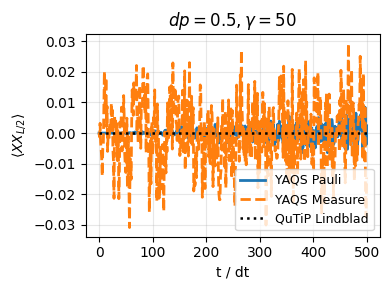

In [ ]:
L = 5
J = 1
h = 1
T = 5
dt = 0.1

H = ising_hamiltonian(L, J, h)
# H = heisenberg_xxx_hamiltonian(L, J, h)
H_0 = MPO()
H_0.init_ising(L, J, h)
# H_0.init_heisenberg(L, J, J, J, h)

dp_list = np.logspace(-4, 0, 100)

# --- create subplots ---
n_dp = len(dp_list)
fig, axes = plt.subplots(1, n_dp, figsize=(4*n_dp, 3))
if n_dp == 1:
    axes = [axes]

# -----------------------------
# QuTiP + YAQS comparison
# -----------------------------
for ax, dp in zip(axes, dp_list):
    dp = 0.5
    dt = 0.01
    gamma = 50
    # gamma = dp / dt

    # ----- YAQS -----
    # Unraveling 1
    noise_model = NoiseModel([
        {"name": name, "sites": [i], "strength": gamma}
        for i in range(L)
        for name in ["pauli_z", "pauli_x", "pauli_y"]
    ])
    cost = tdvp_simulator(H_0, noise_model, dt)
    ax.plot(
        # np.arange(0.0, T + 1e-6, dt),
        cost[0].results,
        lw=2,
        label="YAQS Pauli",
    )

    # Unraveling 2
    noise_model = NoiseModel([
        {"name": name, "sites": [i], "strength": 2*gamma}
        for i in range(L)
        for name in [
            "measure_0", "measure_1",
            "measure_x_0", "measure_x_1",
            "measure_y_0", "measure_y_1",
        ]
    ])
    cost = tdvp_simulator(H_0, noise_model, dt)
    ax.plot(
        # np.arange(0.0, T + 1e-6, dt),
        cost[0].results,
        lw=2,
        linestyle="--",
        label="YAQS Measure",
    )

    # ----- QuTiP Lindblad -----
    c_ops = pauli_c_ops(L, gamma)
    results3, tlist = qutip_lindblad_simulator(
        H, c_ops, L, dt=dt, T=T
    )
    ax.plot(
        # tlist,
        results3[0],
        "k:",
        lw=1.8,
        label="QuTiP Lindblad",
    )

    ax.set_title(f"$dp={dp},\\gamma={gamma}$")
    ax.set_xlabel("t / dt")
    ax.grid(alpha=0.3)

axes[0].set_ylabel(r"$\langle XX_{L/2}\rangle$")
axes[0].legend(loc="best", fontsize=9)

plt.tight_layout()
plt.show()